# Neighborhood Computations

In [179]:
import numpy as np
import igl
import math
import random
import meshplot as mp
import scipy as sp
import ipywidgets as iw

import vispy
from vispy import io
from vispy import app, gloo
from vispy.gloo import Program
from PIL import Image
import jupyter_rfb

## Defining Feature Edges With Dihedral Angle Thresholding
### TODO: User Constraints?
Not sure how to implememt click-to-select vertices/faces, but maybe user-inputted list?

In [304]:
def feature_edges(v,f,threshold):
    edge_faces = []

    dihedral_threshold = threshold/180 * np.pi
    f_normals = igl.per_face_normals(v,f,np.ndarray([0,0]))
    edge_flaps = igl.edge_flaps(f)
    edges = edge_flaps[0]
    
    threshold_edges = []
    for i in range(edges.shape[0]):
        # find normals of faces connecting edge
        edge_face_norms = f_normals[edge_flaps[2][i]]

        # find dihedral angle between edge faces
        f1n = edge_face_norms[0] / np.linalg.norm(edge_face_norms[0])
        f2n = edge_face_norms[1] / np.linalg.norm(edge_face_norms[1])
        dihedral_angle = np.arccos(np.clip(np.dot(f1n, f2n), -1.0, 1.0))

        # add angles greater than threshold to list
        if dihedral_angle > dihedral_threshold or (-1 in edge_flaps[2][i]):
            threshold_edges.append(edges[i])
            
            # add edge faces to list
            if edge_flaps[2][i][0] != -1:
                edge_faces.append(edge_flaps[2][i][0])
            if edge_flaps[2][i][1] != -1:
                edge_faces.append(edge_flaps[2][i][1])

    threshold_edges = np.array(threshold_edges)
    return threshold_edges, edge_faces



v, f = igl.read_triangle_mesh("data/curve.off")
feature_edge_list, edge_faces = feature_edges(v,f,20)

col = np.ones_like(f)
col[edge_faces, 1:] = 0

p = mp.plot(v, f, c=col, shading={"wireframe": 0})
p.add_lines(v[feature_edge_list][:,0], v[feature_edge_list][:,1], shading={"line_color": "yellow"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

1

## Parametrization onto Square Map

In [307]:
def circle_to_square(x_circ,y_circ):
    x = 0.5 * np.sqrt( 2 + x_circ**2 - y_circ**2 + 2*x_circ*np.sqrt(2) ) - 0.5 * np.sqrt( 2 + x_circ**2 - y_circ**2 - 2*x_circ*np.sqrt(2) )
    y = 0.5 * np.sqrt( 2 - x_circ**2 + y_circ**2 + 2*y_circ*np.sqrt(2) ) - 0.5 * np.sqrt( 2 - x_circ**2 + y_circ**2 - 2*y_circ*np.sqrt(2) )
    x = round(max(min(1,x),-1),5)
    y = round(max(min(1,y),-1),5)
    return [x,y]

def parametrize(v,f):
    ## Find the open boundary
    bnd = igl.boundary_loop(f)
    
    ## Map the boundary to a circle, preserving edge proportions
    bnd_uv = igl.map_vertices_to_circle(v, bnd)
    
    # remap circle boundary onto square
    bnd_uv = np.array([circle_to_square(x_circ,y_circ) for [x_circ,y_circ] in bnd_uv])

    # force points into corners
    TL = np.array([-1,1])
    TR = np.array([1,1])
    BL = np.array([-1,-1])
    BR = np.array([1,-1])
    bndTL = 0
    bndTR = 0
    bndBL = 0
    bndBR = 0
    for coordi, coord in enumerate(bnd_uv):
        if np.linalg.norm(coord-TL) < np.linalg.norm(bnd_uv[bndTL]-TL):
            bndTL = coordi
        if np.linalg.norm(coord-TR) < np.linalg.norm(bnd_uv[bndTR]-TR):
            bndTR = coordi
        if np.linalg.norm(coord-BL) < np.linalg.norm(bnd_uv[bndBL]-BL):
            bndBL = coordi
        if np.linalg.norm(coord-BR) < np.linalg.norm(bnd_uv[bndBR]-BR):
            bndBR = coordi

    bnd_uv[bndTL] = TL
    bnd_uv[bndTR] = TR
    bnd_uv[bndBL] = BL
    bnd_uv[bndBR] = BR
    ## Harmonic parametrization for the internal vertices
    return igl.harmonic(v, f, bnd, bnd_uv, 1)


v, f = igl.read_triangle_mesh("data/curve.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,20)


p = mp.plot(v, f, c=np.ones_like(f), shading={"wireframe": False})
p.add_lines(v[feature_edge_list][:,0], v[feature_edge_list][:,1], shading={"line_color": "yellow"})
@iw.interact(mode=['2D','3D'])
def switch(mode):
    if mode == "3D":
        mp.plot(v, f, c=uv[:,0],shading={"wireframe": 0}, plot=p)
        p.add_lines(v[feature_edge_list][:,0], v[feature_edge_list][:,1], shading={"line_color": "yellow"})
        
    if mode == "2D":
        mp.plot(uv, f, c=np.ones_like(f), shading={"wireframe": 1, "line_width":0.2}, plot=p)
        p.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        p.add_points(uv, shading={"point_size": .04})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

interactive(children=(Dropdown(description='mode', options=('2D', '3D'), value='2D'), Output()), _dom_classes=…

## Geometry Maps

### 1. Area Distortion Map

In [306]:
def normalizeZeroToOne(arr):
    if(min(arr) < 0):
        arr -= min(arr)
    return (1/max(arr)) * arr
    
def areaDistortion(v,uv,f):
    a3d = igl.doublearea(v,f)
    a2d = igl.doublearea(uv,f)

    VF, NI = igl.vertex_triangle_adjacency(f,v.shape[0])
    face_area_distortion = a3d/a2d

    vert_area_distortion = np.zeros_like(v[:,0])
    for i in range(v.shape[0]):
        face0 = NI[i]
        facen = NI[i+1]
        faces = VF[face0:facen]
        faceAreas = a3d[faces]
        faceAreas = (1/np.sum(faceAreas)) * faceAreas
        #print(i, faces,faceAreas)

        vertAD = 0
        for facei, face in enumerate(faces):
            vertAD += face_area_distortion[face] * faceAreas[facei]
        vert_area_distortion[i] = vertAD

    return normalizeZeroToOne(vert_area_distortion)


v, f = igl.read_triangle_mesh("data/curve.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)
area_distortion = areaDistortion(v,uv,f)

a = mp.plot(uv, f, c=area_distortion, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2

### 2. Curvature Maps

In [183]:
def curveMaps(v,f):
    gaussCurv = igl.gaussian_curvature(v,f)
    _, _, maxCurv, minCurv = igl.principal_curvature(v, f)
    totalCurv = maxCurv * maxCurv + minCurv * minCurv

    gaussCurv = normalizeZeroToOne(gaussCurv * gaussCurv)
    maxCurv = normalizeZeroToOne(maxCurv)
    minCurv = normalizeZeroToOne(minCurv)
    totalCurv = normalizeZeroToOne(totalCurv)

    return gaussCurv, maxCurv, minCurv, totalCurv


v, f = igl.read_triangle_mesh("data/curve.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)
gaussCurv, maxCurv, minCurv, totalCurv = curveMaps(v,f)

a = mp.plot(uv, f, c=gaussCurv, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
@iw.interact(mode=['Gaussian','Max','Min','Total'])
def switch(mode):
    if mode == "Gaussian":
        mp.plot(uv, f, c=gaussCurv, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "Max":
        mp.plot(uv, f, c=maxCurv, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "Min":
        mp.plot(uv, f, c=minCurv, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "Total":
        mp.plot(uv, f, c=totalCurv, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

interactive(children=(Dropdown(description='mode', options=('Gaussian', 'Max', 'Min', 'Total'), value='Gaussia…

### 3. Embedding Map

In [184]:
def scalarToRGB(scalarMap):
    rgbMap = []
    for i in range(scalarMap.shape[0]):
        r = scalarMap[i]
 
        g = max(0,(scalarMap[i]-1/3))
 
        b = max(0,(scalarMap[i]-2/3))
            
        rgbMap.append([r,g,b])
    return np.array(rgbMap)

def embeddingMaps(v):
    xMap = v[:,0].copy()
    yMap = v[:,1].copy()
    zMap = v[:,2].copy()
    xMap = normalizeZeroToOne(xMap)
    yMap = normalizeZeroToOne(yMap)
    zMap = normalizeZeroToOne(zMap)
    
    return scalarToRGB(xMap), scalarToRGB(yMap), scalarToRGB(zMap)

v, f = igl.read_triangle_mesh("data/curve.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)
xMap, yMap, zMap = embeddingMaps(v)

a = mp.plot(uv, f, c=v, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
@iw.interact(mode=['Vertex Position','xMap','yMap','zMap'])
def switch(mode):
    if mode == "Vertex Position":
        mp.plot(uv, f, c=v, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "xMap":
        mp.plot(uv, f, c=xMap, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "yMap":
        mp.plot(uv, f, c=yMap, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "zMap":
        mp.plot(uv, f, c=zMap, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

interactive(children=(Dropdown(description='mode', options=('Vertex Position', 'xMap', 'yMap', 'zMap'), value=…

### 4. Face Index Map

In [185]:
def indexMap(v,f):
    face_index_list = []
    face_index_map = {}
    
    for i in range(f.shape[0]):
        face_col = [random.uniform(0,255),random.uniform(0,255),random.uniform(0,255)]
        face_index_list.append(face_col)
        while str(face_index_list[i]) in face_index_map:
            face_index_list[i] = [random.uniform(0,255),random.uniform(0,255),random.uniform(0,255)]
        face_index_map[str(face_index_list[i])] = i
        
    face_index_list = np.array(face_index_list)
    return face_index_list, face_index_map

random.seed(1)
v, f = igl.read_triangle_mesh("data/curve.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)
face_index_list, face_index_map = indexMap(v,f)
face_index_list = (1/255) * face_index_list

a = mp.plot(uv, f, c=face_index_list, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2

### 5. (optional) Additional Maps

ex: normal, texture, color

Useful if the remeshed model needs these attributes added after remeshing, not needed for remeshing process itself.

In [186]:
v, f = igl.read_triangle_mesh("data/curve.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)

v_p = np.hstack([uv, np.zeros((uv.shape[0],1))])
pvn = igl.per_vertex_normals(v,f)

a = mp.plot(uv, f, c=pvn, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2

## Combining Maps to Create Control Map

In [187]:
def designControlMap(v,f):
    uv = parametrize(v,f)
    feature_edge_list, _ = feature_edges(v,f,10)
    
    area_distortion = areaDistortion(v,uv,f)
    gaussCurv, maxCurv, minCurv, totalCurv = curveMaps(v,f)

    areaDistortionFactor = 0.5
    gaussCurvFactor = 0.5
    maxCurvFactor = 0.5
    minCurvFactor = 0.5
    totalCurvFactor = 0.5
    
    controlMap =  areaDistortionFactor * area_distortion + gaussCurvFactor * gaussCurv + maxCurvFactor * maxCurv + minCurvFactor * minCurv + totalCurvFactor * totalCurv
    controlMap = normalizeZeroToOne(controlMap)

    a = mp.plot(uv, f, c=controlMap, shading={"wireframe": 0, "line_width":0.2})
    @mp.interact(areaDistortionFactor = (0.0,1.0),gaussCurvFactor = (0.0,1.0),maxCurvFactor = (0.0,1.0),minCurvFactor = (0.0,1.0),totalCurvFactor = (0.0,1.0))
    def ff(areaDistortionFactor, gaussCurvFactor,maxCurvFactor,minCurvFactor,totalCurvFactor):
        controlMap =  areaDistortionFactor * area_distortion + gaussCurvFactor * gaussCurv + maxCurvFactor * maxCurv + minCurvFactor * minCurv + totalCurvFactor * totalCurv
        controlMap = normalizeZeroToOne(controlMap)
        mp.plot(uv, f, c=controlMap, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        print(areaDistortionFactor,",",gaussCurvFactor,",",maxCurvFactor,",",minCurvFactor,",",totalCurvFactor)

v, f = igl.read_triangle_mesh("data/curve.off")

feature_edge_list, _ = feature_edges(v,f,10)
xMap, yMap, zMap = embeddingMaps(v)
uv = parametrize(v,f)
designControlMap(v,f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

interactive(children=(FloatSlider(value=0.5, description='areaDistortionFactor', max=1.0), FloatSlider(value=0…

In [286]:
def createControlMap(v,f,
                     areaDistortionFactor,gaussCurvFactor,maxCurvFactor,minCurvFactor,totalCurvFactor
                    ):
    uv = parametrize(v,f)    
    area_distortion = areaDistortion(v,uv,f)
    gaussCurv, maxCurv, minCurv, totalCurv = curveMaps(v,f)
    controlMap =  areaDistortionFactor * area_distortion + gaussCurvFactor * gaussCurv + maxCurvFactor * maxCurv + minCurvFactor * minCurv + totalCurvFactor * totalCurv
    return normalizeZeroToOne(controlMap)

controlMap = createControlMap(v,f,
                             1.0 , 0.0 , 0.0 , 0.0 , 0.0
                             )
mp.plot(uv, f, c=controlMap, shading={"wireframe": 0, "line_width":0.2, "colormap": "Greys"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [287]:
def buildGLBuffers(uv,f,map):
    vertexBuffer = []
    colorBuffer = []
    if (map.shape[0] == uv.shape[0]):
        if (len(map.shape) > 1):
            for face in f:
                for vert in face:
                    vertexBuffer.append(tuple(uv[vert]))
                    colorBuffer.append((map[vert][0],map[vert][1],map[vert][2],0))
        else:
            for face in f:
                for vert in face:
                    vertexBuffer.append(tuple(uv[vert]))
                    colorBuffer.append((map[vert],map[vert],map[vert],0))
                
    if (map.shape[0] == f.shape[0]):
        if (len(map.shape) > 1):
            for facei, face in enumerate(f):
                for vert in face:
                    vertexBuffer.append(tuple(uv[vert]))
                    colorBuffer.append((map[facei][0],map[facei][1],map[facei][2],0))
                    
    return vertexBuffer, colorBuffer


In [288]:
class Canvas(app.Canvas):
    def __init__(self):
        super().__init__(size=(256, 256))

        self.program = Program(vertex, fragment, len(vertexBuffer))
        self.program['color'] = colorBuffer
        self.program['position'] = vertexBuffer
        
        gloo.set_viewport(0, 0, *self.physical_size)

        self.show()

    def on_draw(self, event):
        gloo.clear()
        self.program.draw('triangles')

    def on_resize(self, event):
        gloo.set_viewport(0, 0, *event.physical_size)

RFBOutputContext()

CanvasBackend(css_height='256px', css_width='256px')
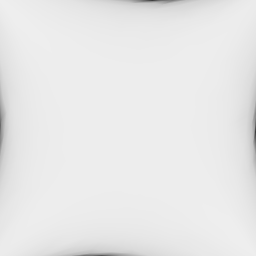

In [289]:
vertex = """
    attribute vec4 color;
    attribute vec2 position;
    varying vec4 v_color;
    void main()
    {
        gl_Position = vec4(position, 0.0, 1.0);
        v_color = vec4(1,1,1,1)-color;
    } """

fragment = """
    varying vec4 v_color;
    void main()
    {
        gl_FragColor = v_color;
    } """

vertexBuffer, colorBuffer =  buildGLBuffers(uv,f,controlMap)


c = Canvas()
c

In [290]:
img=c.render('triangle_strip')
vispy.io.image.write_png("controlMap.png", img)

RFBOutputContext()

CanvasBackend(css_height='256px', css_width='256px')
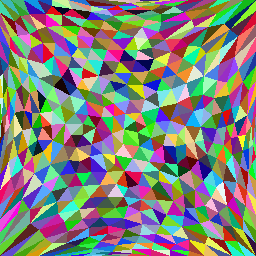

In [291]:
vertex = """
    attribute vec4 color;
    attribute vec2 position;
    varying vec4 v_color;
    void main()
    {
        gl_Position = vec4(position, 0.0, 1.0);
        v_color = vec4(color.rgb,1);
    } """

fragment = """
    varying vec4 v_color;
    void main()
    {
        gl_FragColor = v_color;
    } """

vertexBuffer, colorBuffer = buildGLBuffers(uv,f,face_index_list)

c = Canvas()
c

In [292]:
img=c.render('triangle_strip')
vispy.io.image.write_png("faceIndexMap.png", img)

RFBOutputContext()

CanvasBackend(css_height='256px', css_width='256px')
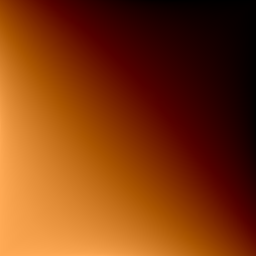

In [293]:
vertex = """
    attribute vec4 color;
    attribute vec2 position;
    varying vec4 v_color;
    void main()
    {
        gl_Position = vec4(position, 0.0, 1.0);
        v_color = vec4(color.rgb,1);
    } """

fragment = """
    varying vec4 v_color;
    void main()
    {
        gl_FragColor = v_color;
    } """

vertexBuffer, colorBuffer = buildGLBuffers(uv,f,xMap)
c = Canvas()
c

In [294]:
img=c.render('triangle_strip')
vispy.io.image.write_png("xMap.png", img)

RFBOutputContext()

CanvasBackend(css_height='256px', css_width='256px')
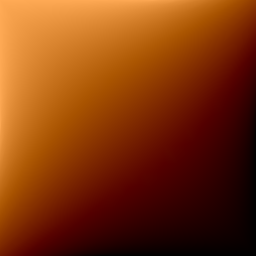

In [295]:
vertexBuffer, colorBuffer = buildGLBuffers(uv,f,yMap)
c = Canvas()
c

In [296]:
img=c.render('triangle_strip')
vispy.io.image.write_png("yMap.png", img)

RFBOutputContext()

CanvasBackend(css_height='256px', css_width='256px')
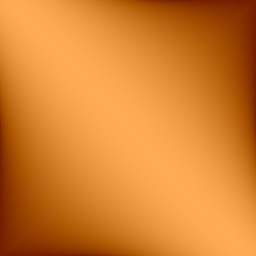

In [297]:
vertexBuffer, colorBuffer = buildGLBuffers(uv,f,zMap)
c = Canvas()
c

In [298]:
img=c.render('triangle_strip')
vispy.io.image.write_png("zMap.png", img)

In [299]:
# https://github.com/10mrohit/floyd-steinberg-dithering
from math import floor
from PIL import Image

import os

class Dither():
    def __init__(self, path, algorithm=None, output=None):
        self.path = self.get_path(path)
        self.algorithm = algorithm
        self.output = output
        self.func = self.get_func(self.algorithm)
        self.func(self.path)

    def get_path(self, path):
        if path.startswith('/') and not path.startswith('~/'):
            return os.getcwd() + '/' + path
        else:
            return path

    def get_func(self, algorithm):
        return self.floyd_steinberg_dither

    def apply_threshold(self, value):
        return 255 * floor(value/128)

    def floyd_steinberg_dither(self, image_file):
        new_img = Image.open(image_file)

        new_img = new_img.convert('RGB')
        pixel = new_img.load()

        x_lim, y_lim = new_img.size

        for y in range(1, y_lim):
            for x in range(1, x_lim):
                oldpixel, _, _ = pixel[x, y]
                newpixel = self.apply_threshold(oldpixel)
              
                pixel[x, y] = newpixel, newpixel, newpixel

                error = oldpixel - newpixel
            
                if x < x_lim - 1:
                    value = pixel[x+1, y][0] + round(error * 7/16)
                    pixel[x+1, y] = (value, value, value)

                if x > 1 and y < y_lim - 1:
                    value = pixel[x-1, y+1][0] + round(error * 3/16)
                    pixel[x-1, y+1] = (value, value, value)

                if y < y_lim - 1:
                    value = pixel[x, y+1][0] + round(error * 5/16)
                    pixel[x, y+1] = (value, value, value)

                if x < x_lim - 1 and y < y_lim - 1:
                    value = pixel[x+1, y+1][0] + round(error * 1/16)
                    pixel[x+1, y+1] = (value, value, value)

        if self.output:
            new_img.save(self.output)
        else:
            new_img.show()

In [300]:
Dither("controlMap.png", output="discreteControlMap.png")

In [301]:
def imageToMapCoords(imgX,imgY,height,width):
    x = (imgX*2-width) / width
    y = -(imgY*2-height) / height
    return x,y

def mapToImageCoords(mapX, mapY, height, width):
    x = (mapX + 1)/2 * width
    y = (-mapY + 1)/2 * height

    x = min(int(x), width-1)
    y = min(int(y), height-1)
    return x,y
    
def uvFromControlMap(filename):
    newUV = []
    im = np.array(Image.open(filename))

    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (im[y,x,0] == 0):
                u,v=imageToMapCoords(x,y,im.shape[0],im.shape[1])
                newUV.append([u,v])
    return np.array(newUV)
            
newUV=uvFromControlMap("discreteControlMap.png")

## add constraints
for coord in uv[feature_edge_list]:
    newUV = np.append(newUV, coord, axis=0)
bnd = igl.boundary_loop(f)
bnd_uv = igl.map_vertices_to_circle(v, bnd)
bnd_uv = np.array([circle_to_square(x_circ,y_circ) for [x_circ,y_circ] in bnd_uv])
newUV = np.append(newUV, bnd_uv, axis=0)
#########################

delauney = sp.spatial.Delaunay(newUV).simplices

p=mp.plot(newUV, delauney, shading={"wireframe": 1, "line_width":0.9})
p.add_points(newUV, shading={"point_size": .06, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

1

In [302]:
def uvMapToXYZ(uvCoords, v, xMapImg, yMapImg, zMapImg):
    newV = []
    Xim = np.array(Image.open(xMapImg))
    Yim = np.array(Image.open(yMapImg))
    Zim = np.array(Image.open(zMapImg))

    xRange = max(v[:,0]) - min(v[:,0])
    print(xRange)
    yRange = max(v[:,1]) - min(v[:,1])
    print(yRange)
    zRange = max(v[:,2]) - min(v[:,2])
    print(zRange)
    
    for [xMap, yMap] in uvCoords:
        imX, imY = mapToImageCoords(xMap, yMap, Xim.shape[0], Xim.shape[1])
        uvXYZ = [xRange*np.sum(Xim[imY,imX]),
                 yRange*np.sum(Yim[imY,imX]),
                 zRange*np.sum(Zim[imY,imX])]
        newV.append(uvXYZ)

    return (1/255)*np.array(newV)


newV = uvMapToXYZ(newUV, v, "xMap.png", "yMap.png", "zMap.png")


p=mp.plot(newV, delauney, shading={"wireframe": 1, "line_width":0.2})

2.0
2.0
0.6180300000000001


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.0, 4.0,…